In [1]:
# common import abbreviations
import numpy as np
import matplotlib.pyplot as plt
import matplotlib as mpl
import seaborn as sns
import pandas as pd
import patsy

import itertools as it
import collections as co
import functools as ft
import os.path as osp

import glob
import textwrap

# finally, a better idiom for warnings
import sklearn, warnings
warnings.filterwarnings('ignore',
                        category=FutureWarning,
                        module='sklearn')

warnings.filterwarnings('ignore',
                        category=FutureWarning,
                        module='tensor*')

# if the warnings get overwhelming,
# you can re-disable with these original lines:
#import warnings
#warnings.filterwarnings("ignore")

# and for the really aggressive warnings:
# some warnings are stubborn in the extreme, we don't want
# them in the book
#def warn(*args, **kwargs):  pass
#warnings.warn = warn

# config related
np.set_printoptions(precision=4,
                    suppress=True)
pd.options.display.float_format = '{:20,.4f}'.format

# there are good reasons *NOT* to do this in any real production code
# for our purposes (writing a book with completely reproducable output)
# this *is* what we want
np.random.seed(42)

# default is [6.4, 4.8]  (4:3)
mpl.rcParams['figure.figsize'] = [4.0, 3.0]

# turn on latex tables
# pd.set_option('display.latex.repr', True)
pd.set_option('styler.render.repr', 'latex')
# monkey-patch for centering Out[] DataFrames
def _repr_latex_(self):
    return "{\centering\n%s\n\medskip}" % self.to_latex()
pd.DataFrame._repr_latex_ = _repr_latex_

# only used once
markers = it.cycle(['+', '^', 'o', '_', '*', 'd', 'x', 's'])


# handy helper for displaying stuff
from IPython.display import Image

#
# sklearn's packaging is very java-esque.  :(
#
from sklearn import (cluster,
                     datasets,
                     decomposition,
                     discriminant_analysis,
                     dummy,
                     ensemble,
                     feature_selection as ftr_sel,
                     linear_model,
                     metrics,
                     model_selection as skms,
                     multiclass as skmulti,
                     naive_bayes,
                     neighbors,
                     pipeline,
                     preprocessing as skpre,
                     svm,
                     tree)


# the punch line is to predict for a large grid of data points
# http://scikit-learn.org/stable/auto_examples/neighbors/plot_classification.html
def plot_boundary(ax, data, tgt, model, dims, grid_step = .01):
    # grab a 2D view of the data and get limits
    twoD = data[:, list(dims)]
    min_x1, min_x2 = np.min(twoD, axis=0) + 2 * grid_step
    max_x1, max_x2 = np.max(twoD, axis=0) - grid_step


    # make a grid of points and predict at them
    xs, ys = np.mgrid[min_x1:max_x1:grid_step,
                      min_x2:max_x2:grid_step]
    grid_points = np.c_[xs.ravel(), ys.ravel()]
    # warning:  non-cv fit
    preds = model.fit(twoD, tgt).predict(grid_points).reshape(xs.shape)

    # plot the predictions at the grid points
    ax.pcolormesh(xs,ys,preds,shading='auto',cmap=plt.cm.coolwarm)
    ax.set_xlim(min_x1, max_x1)#-grid_step)
    ax.set_ylim(min_x2, max_x2)#-grid_step)

def plot_separator(model, xs, ys, label='', ax=None):
    ''' xs, ys are 1-D b/c contour and decision_function
        use incompatible packaging '''
    if ax is None:
        ax = plt.gca()

    xy = np_cartesian_product(xs, ys)
    z_shape = (xs.size, ys.size) # verus shape[0]?
    zs = model.decision_function(xy).reshape(z_shape)

    contours = ax.contour(xs, ys, zs,
                          colors='k', levels=[0],
                          linestyles=['-'])
    fmt = {contours.levels[0] : label}
    labels = ax.clabel(contours, fmt=fmt, inline_spacing=10)
    [l.set_rotation(-90) for l in labels]

def high_school_style(ax):
    ' helper to define an axis to look like a typical school plot '
    ax.spines['left'].set_position(('data', 0.0))
    ax.spines['bottom'].set_position(('data', 0.0))
    ax.spines['right'].set_visible(False)
    ax.spines['top'].set_visible(False)

    def make_ticks(lims):
        lwr, upr = sorted(lims) #x/ylims can be inverted in mpl
        lwr = np.round(lwr).astype('int') # can return np objs
        upr = np.round(upr).astype('int')
        if lwr * upr < 0:
            return list(range(lwr, 0)) + list(range(1,upr+1))
        else:
            return list(range(lwr, upr+1))

    import matplotlib.ticker as ticker
    xticks = make_ticks(ax.get_xlim())
    yticks = make_ticks(ax.get_ylim())

    ax.xaxis.set_major_locator(ticker.FixedLocator(xticks))
    ax.yaxis.set_major_locator(ticker.FixedLocator(yticks))

    ax.set_aspect('equal')

def get_model_name(model):
    ' return name of model (class) as a string '
    return str(model.__class__).split('.')[-1][:-2]

def rdot(w,x):
    ' apply np.dot on swapped args '
    return np.dot(x,w)

from sklearn.base import BaseEstimator, ClassifierMixin
class DLDA(BaseEstimator, ClassifierMixin):
    def __init__(self):
        pass

    def fit(self, train_ftrs, train_tgts):
        self.uniq_tgts = np.unique(train_tgts)
        self.means, self.priors = {}, {}

        self.var  = train_ftrs.var(axis=0) # biased
        for tgt in self.uniq_tgts:
            cases = train_ftrs[train_tgts==tgt]
            self.means[tgt]  = cases.mean(axis=0)
            self.priors[tgt] = len(cases) / len(train_ftrs)
        return self

    def predict(self, test_ftrs):
        disc = np.empty((test_ftrs.shape[0],
                         self.uniq_tgts.shape[0]))
        for tgt in self.uniq_tgts:
            # technically, the maha_dist is sqrt() of this:
            mahalanobis_dists = ((test_ftrs - self.means[tgt])**2 /
                                 self.var)
            disc[:,tgt] = (-np.sum(mahalanobis_dists, axis=1) +
                           2 * np.log(self.priors[tgt]))
        return np.argmax(disc,axis=1)


def plot_lines_and_projections(axes, lines, points, xs):
    data_xs, data_ys = points[:,0], points[:,1]
    mean = np.mean(points, axis=0, keepdims=True)
    centered_data = points - mean

    for (m,b), ax in zip(lines, axes):
        mb_line = m*xs + b
        v_line = np.array([[1, 1/m if m else 0]])

        ax.plot(data_xs, data_ys, 'r.') # uncentered
        ax.plot(xs, mb_line, 'y')      # uncentered
        ax.plot(*mean.T, 'ko')

        # centered data makes the math easier!
        # this is length on yellow line from red to blue
        # distance from mean to projected point
        y_lengths = centered_data.dot(v_line.T) / v_line.dot(v_line.T)
        projs = y_lengths.dot(v_line)

        # decenter (back to original coordinates)
        final = projs + mean
        ax.plot(*final.T, 'b.')

        # connect points to projections
        from matplotlib import collections as mc
        proj_lines = mc.LineCollection(zip(points,final))
        ax.add_collection(proj_lines)

        hypots = zip(points, np.broadcast_to(mean, points.shape))
        mean_lines = mc.LineCollection(hypots, linestyles='dashed')
        ax.add_collection(mean_lines)

# adding an orientation would be nice
def sane_quiver(vs, ax=None, colors=None, origin=(0,0)):
    '''plot row vectors from origin'''
    vs = np.asarray(vs)
    assert vs.ndim == 2 and vs.shape[1] == 2  # ensure column vectors
    n = vs.shape[0]
    if not ax: ax = plt.gca()

    orig_x, orig_y = origin
    xs = vs.T[0]  # column to rows, row[0] is xs
    ys = vs.T[1]

    # highly annoying:  quiver doesn't broadcast anymore (?)
    orig_x = np.full_like(xs, orig_x)
    orig_x = np.full_like(xs, orig_x)

    props = {"angles":'xy', 'scale':1, 'scale_units':'xy'}
    ax.quiver(orig_x, orig_y, xs, ys, color=colors, **props)

    ax.set_aspect('equal')
    # ax.set_axis_off()
    _min, _max = min(vs.min(), 0) -1, max(0, vs.max())+1
    ax.set_xlim(_min, _max)
    ax.set_ylim(_min, _max)

def reweight(examples, weights):
    ''' convert weights to counts of examples using approximately two
        significant digits of weights.

        there are probably a 100 reasons not to do this like this.
        top 2:
          1.  boosting may require more precise values (or using randomization)
              to keep things unbiased
          2.  this *really* expands the dataset to a significant degree
              (wastes resources)
    '''
    from math import gcd
    from functools import reduce

    # who needs repeated the least?
    min_wgt = min(weights)
    min_replicate = 1 / min_wgt # e.g., .25 -> 4

    # compute naive duplication to 2 decimal places
    counts = (min_replicate * weights * 100).astype(np.int64)

    # trim duplication if we can
    our_gcd = reduce(gcd, counts)
    counts = counts // our_gcd

    # repeat is picky about type
    return np.repeat(examples, counts, axis=0)

#examples = np.array([1, 10, 20])
#weights  = np.array([.25, .33, 1-(.25+.33)])
# print(pd.Series(reweight(examples, weights)))

def enumerate_outer(outer_seq):
    '''repeat the outer idx based on len of inner'''
    return np.repeat(*zip(*enumerate(map(len, outer_seq))))

def np_array_fromiter(itr, shape, dtype=np.float64):
    ''' helper since np.fromiter only does 1D'''
    arr = np.empty(shape, dtype=dtype)
    for idx, itm in enumerate(itr):
        arr[idx] = itm
    return arr

# how do you figure out arcane code?
# work inside out, small inputs, pay attention to datatypes.
# try outter and righter calls with simpler inputs
# read docs *in conjunction with* experiments
# [the docs rarely make sense - to me - in the abstract until I try
#  examples while reading them]

# the difference with a "raw" np.meshgrid call is we stack these up in
# two columns of results (i.e., we make a table out of the pair arrays)
def np_cartesian_product(*arrays):
    ''' some numpy kung-fu to produce all
        possible combinations of input arrays '''
    ndim = len(arrays)
    return np.stack(np.meshgrid(*arrays), axis=-1).reshape(-1, ndim)

# replacement for tsplot is happiest with
# "tidy" data
# tidying the numpy array is a bit of a pain
# xarray is designed to do this "natively" but
# i don't want to introduce that dependency
# [seems like there could be a better broadcasting
#  solution to this]
def sk_graph_to_tidy(train_test_scores, # y values
                     eval_points,       # x values
                     eval_label,        # x column name
                     num_folds):        # could be inferred
    train_scores, test_scores = train_test_scores
    # humph, didn't know np_cartesian was order sensitive
    labels = np_cartesian_product(eval_points,
                                  [0,1], # surrogates for train/test
                                  np.arange(num_folds))
    score = np.concatenate([train_scores.flatten(),
                            test_scores.flatten()], axis=0)

    df = pd.DataFrame.from_records(labels)
    df.columns = [eval_label, 'set', 'fold']
    df.set = df.set.replace({0:'Train', 1:'Test'})
    df['score'] = score
    return df

## Binary Classification

In [3]:
# setup

%matplotlib inline

In [4]:
iris = datasets.load_iris()

iris_df = pd.DataFrame(iris.data,
                       columns=iris.feature_names)
iris_df['target'] = iris.target
display(pd.concat([iris_df.head(3),
                   iris_df.tail(3)]))

,sepal length (cm),sepal width (cm),petal length (cm),petal width (cm),target
0,5.1000,3.5000,1.4000,0.2000,0
1,4.9000,3.0000,1.4000,0.2000,0
2,4.7000,3.2000,1.3000,0.2000,0
147,6.5000,3.0000,5.2000,2.0000,2
148,6.2000,3.4000,5.4000,2.3000,2
149,5.9000,3.0000,5.1000,1.8000,2


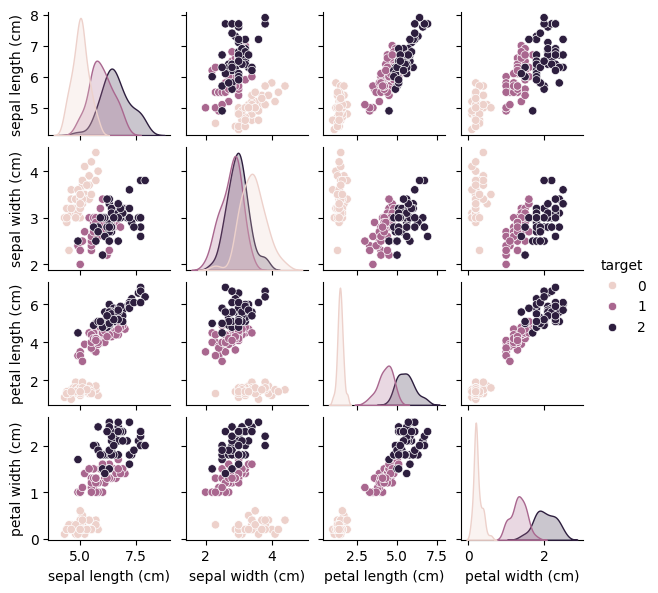

In [5]:
sns.pairplot(iris_df, hue='target', height=1.5);

In [6]:
print('targets: {}'.format(iris.target_names),
      iris.target_names[0], sep="\n")

targets: ['setosa' 'versicolor' 'virginica']
setosa


In [7]:
# simple train/test split
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt,  iris_test_tgt) = skms.train_test_split(iris.data,
                                                         iris.target,
                                                         test_size=.25)
print("Train features shape:", iris_train_ftrs.shape)
print("Test features shape:",  iris_test_ftrs.shape)

Train features shape: (112, 4)
Test features shape: (38, 4)


In [8]:
answer_key = np.array([True, True, False, True])
student_answers = np.array([True, True, True, True]) # desperate student!

In [9]:
correct = answer_key == student_answers
num_correct = correct.sum() # True == 1, add them up
print("manual accuracy:", num_correct / len(answer_key))

manual accuracy: 0.75


In [10]:
print("sklearn accuracy:",
      metrics.accuracy_score(answer_key,
                             student_answers))

sklearn accuracy: 0.75


In [11]:
# default n_neighbors = 5
knn   = neighbors.KNeighborsClassifier(n_neighbors=3)
fit   = knn.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

# evaluate our predictions against the held-back testing targets
print("3NN accuracy:",
      metrics.accuracy_score(iris_test_tgt, preds))

3NN accuracy: 1.0


In [12]:
nb    = naive_bayes.GaussianNB()
fit   = nb.fit(iris_train_ftrs, iris_train_tgt)
preds = fit.predict(iris_test_ftrs)

print("NB accuracy:",
      metrics.accuracy_score(iris_test_tgt, preds))

NB accuracy: 1.0


In [14]:
# stand alone code
from sklearn import (datasets, metrics,
                     model_selection as skms,
                     naive_bayes, neighbors)

# we set random_state so the results are reproducable
# otherwise, we get different training and testing sets
# more details in Chapter 5
iris = datasets.load_iris()
(iris_train_ftrs, iris_test_ftrs,
 iris_train_tgt, iris_test_tgt) = skms.train_test_split(iris.data,
                                                        iris.target,
                                                        test_size=.90,
                                                        random_state=42)

models = {'kNN': neighbors.KNeighborsClassifier(n_neighbors=3),
          'NB' : naive_bayes.GaussianNB()}

for name, model in models.items():
    fit = model.fit(iris_train_ftrs, iris_train_tgt)
    predictions = fit.predict(iris_test_ftrs)

    score = metrics.accuracy_score(iris_test_tgt, predictions)
    print("{:>3s}: {:0.2f}".format(name,score))

kNN: 0.96
 NB: 0.81


## Evaluating and Comparing Learners
### 1. Split our data into separate training and testing datasets
### 2. Learn on the training data
### 3. Evaluate on the testing data

In [25]:
diabetes = datasets.load_diabetes()
%matplotlib inline

In [27]:
# Overfitting and Underfitting
# Let's create synthetic data set
N = 20
ftr = np.linspace(-10, 10, num=N)                # ftr values
tgt = 2*ftr**2 - 3 + np.random.uniform(-2, 2, N) # add some random noise to data

(train_ftr, test_ftr,
 train_tgt, test_tgt) = skms.train_test_split(ftr, tgt, test_size=N//2)

display(pd.DataFrame({"ftr":train_ftr,
                      "tgt":train_tgt}).T)


,0,1,2,3,4,5,6,7,8,9
ftr,7.8947,1.5789,2.6316,-2.6316,-1.5789,-8.9474,-7.8947,-0.5263,-3.6842,5.7895
tgt,120.9439,0.2678,9.6861,10.3412,1.5649,159.0321,119.9551,-1.0691,24.0879,63.0527


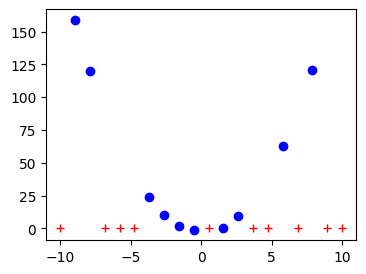

In [29]:
plt.plot(train_ftr, train_tgt, 'bo')
plt.plot(test_ftr,  np.zeros_like(test_ftr), 'r+');
# the blue dots are training set
# red plus '+' signs are the input feature values for test set
# We need to figure out how high up we should take eac of those values

In [31]:
# note: sklearn *really* wants 2D inputs (a table)
# so we use rehape here.
sk_model = linear_model.LinearRegression()
sk_model.fit(train_ftr.reshape(-1,1), train_tgt)
sk_preds = sk_model.predict(test_ftr.reshape(-1,1))
sk_preds[:3]
sk_preds

array([47.1331, 28.8671, 19.7342, 62.3547, 77.5763, 38.0001, 65.399 ,
       68.4433, 34.9558, 22.7785])

In [32]:
#polyfit routine in Numpy  takes input and output values, features, and target and a degree of polynomial
# it calculates the coefficients of the polynomials
# np.poly1d turn those coefficients into a function
model_one = np.poly1d(np.polyfit(train_ftr, train_tgt, 1))
preds_one = model_one(test_ftr)
print(preds_one[:3])

[47.1331 28.8671 19.7342]


In [34]:
# the predictions come back the same
print("all close?", np.allclose(sk_preds, preds_one))


all close? True


In [35]:
# and we can still use sklearn to evaluate it
mse = metrics.mean_squared_error
print("RMSE:", np.sqrt(mse(test_tgt, preds_one)))

RMSE: 84.14542457666431


In [37]:
# What happens when we have curves?
# fit predict evaluate a 2-D polynomial (a parabola)
model_two = np.poly1d(np.polyfit(train_ftr, train_tgt, 2))
preds_two = model_two(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_two)))



RMSE: 1.2909793886261653


## Our Error is reduced by adding a 'bend' Can we add more 'bends' to reduce our error further?

In [38]:
model_three = np.poly1d(np.polyfit(train_ftr, train_tgt, 9))
preds_three = model_three(test_ftr)
print("RMSE:", np.sqrt(mse(test_tgt, preds_three)))

RMSE: 1635.7748053418059


## our Error got worse. What happened?

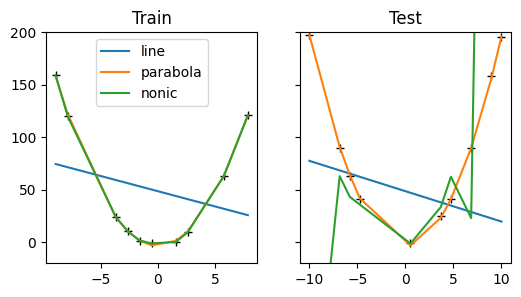

In [39]:
fig, axes = plt.subplots(1,2, figsize=(6,3), sharey=True)

labels = ['line', 'parabola', 'nonic']
models = [model_one, model_two, model_three]
train = (train_ftr, train_tgt)
test  = (test_ftr, test_tgt)

for ax, (ftr, tgt) in zip(axes, [train, test]):
    ax.plot(ftr, tgt, 'k+')
    for m, lbl in zip(models, labels):
        ftr = sorted(ftr)
        ax.plot(ftr, m(ftr), '-', label=lbl)

axes[1].set_ylim(-20, 200)
axes[0].set_title("Train")
axes[1].set_title("Test");
axes[0].legend(loc='upper center');


In [40]:
results = []
for complexity in [1,2,6,9]:
    model = np.poly1d(np.polyfit(train_ftr, train_tgt, complexity))
    train_error = np.sqrt(mse(train_tgt, model(train_ftr)))
    test_error = np.sqrt(mse(test_tgt, model(test_ftr)))
    results.append((complexity, train_error, test_error))

columns = ["Complexity", "Train Error", "Test Error"]
results_df = pd.DataFrame.from_records(results,
                                       columns=columns,
                                       index="Complexity")

results_df


,Train Error,Test Error
Complexity,,
1,55.7271,84.1454
2,1.0553,1.2910
6,0.5823,3.8889
9,0.0000,"1,635.7748"


##Let's review what happenened with models:
### Model One (Complexity 1, straight line) lacks ability to learn complexity. It is too biased to flatness. We call this "underfitting".
### Model Two (Complexity 9, wiggly 9-degree polynomial). It does well on training data but it memorized the 'noise' (randomness) in the data. It fails miserably during testing because it is "overfitting"
### Model Three (Complexity 2, parabola). is the best fit of the three models.

<Axes: xlabel='Complexity'>

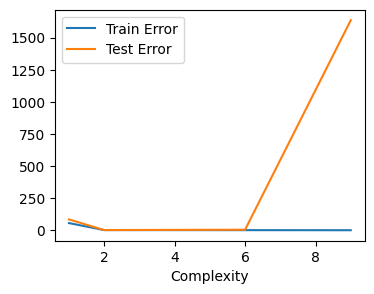

In [41]:
results_df.plot()

## Key takeaway is that we can increase the complexity of the model but it comes with a cost.  We can make the training error very small but when it comes to real world testing it is likely to achieve worse results.

## From Errors to Costs

In [42]:
# loss function that quantifies what happens  when our model is wrong on a single example
# training loss is the sum of the loses on each example
def training_loss(loss, model, training_data):
    ' total training_loss on train_data with model under loss'
    return sum(loss(model.predict(x.reshape(1,-1)), y)
                                 for x,y in training_data)
def squared_error(prediction, actual):
    ' squared error on a single example '
    return (prediction-actual)**2

# could be used like:
# my_training_loss = training_loss(squared_error, model, training_data)

In [43]:
# Let's apply loss function
knn   = neighbors.KNeighborsRegressor(n_neighbors=3)
fit   = knn.fit(diabetes.data, diabetes.target)

training_data = zip(diabetes.data, diabetes.target)

my_training_loss = training_loss(squared_error,
                                 knn,
                                 training_data)
print(my_training_loss)



[863792.3333]


## Cost = training loss + complexity
###  The total cost  we pay to use a model depends on 1) how well it does and 2) how complex it is
### complexity can be computed using techniques: [regularization, smoothing, peanlization, shrinkage]